In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("../")
device="cuda:0"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

In [2]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [3]:
os.makedirs(args.model_path, exist_ok=True)
gaussians_cont = GaussianModel(3)#.to(device=device)
scene_cont = Scene(dataset, gaussians_cont, shuffle=True)
gaussians_cont.training_setup(opt)



Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [4]:
gaussians_cont.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog/chkpnt30000.pth")[0], opt)

In [5]:
os.makedirs(args.model_path, exist_ok=True)
gaussians_stl = GaussianModel(3)#.to(device=device)
scene_stl = Scene(dataset, gaussians_stl, shuffle=True)
gaussians_stl.training_setup(opt)
#gaussians_stl.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks//GT_lego_cluster2_init_200_clusters_hotdog//chkpnt1.pth")[0], opt)
# gaussians_stl.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks//GT_hotdog_lego_ntbk19_save2_no_overlaps2/chkpnt1.pth")[0], opt)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [6]:
# gaussians_stl.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks//GT_lego_cluster2_init_200_clusters_hotdog/chkpnt1.pth")[0], opt)
# gaussians_stl.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks/GT_hotdog_lego_ntbk19_save2_no_overlaps2/chkpnt1.pth")[0], opt)

gaussians_stl.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks/GT_hotdog_lego_ntbk20_init_small_patchesX1.2_scaling/chkpnt1.pth")[0], opt)


In [7]:
gaussians_opt = GaussianModel(3)#.to(device="cuda")
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [49]:
# with torch.no_grad():
gaussians_opt._xyz.data = torch.tensor(gaussians_stl._xyz.data.clone().detach()).to(device=device)
gaussians_opt._features_dc.data = torch.tensor(gaussians_stl._features_dc.data.clone().detach()).to(device=device)
gaussians_opt._features_rest.data = torch.tensor(gaussians_stl._features_rest.data.clone().detach()).to(device=device)
gaussians_opt._rotation.data = torch.tensor(gaussians_stl._rotation.data.clone().detach()).to(device=device)
gaussians_opt._scaling.data = torch.tensor(gaussians_stl._scaling.data.clone().detach()).to(device=device)
gaussians_opt._opacity.data = torch.tensor(gaussians_stl._opacity.data.clone().detach()).to(device=device)
gaussians_opt.max_radii2D.data = torch.tensor(gaussians_stl.max_radii2D.data.clone().detach()).to(device=device)
gaussians_opt.xyz_gradient_accum.data = torch.tensor(gaussians_stl.xyz_gradient_accum.data.clone().detach()).to(device=device)
gaussians_opt.denom.data = torch.tensor(gaussians_stl.denom.data.clone().detach()).to(device=device)

/tmp/ipykernel_4017236/2798528434.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt._xyz.data = torch.tensor(gaussians_stl._xyz.data.clone().detach()).to(device=device)
/tmp/ipykernel_4017236/2798528434.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt._features_dc.data = torch.tensor(gaussians_stl._features_dc.data.clone().detach()).to(device=device)
/tmp/ipykernel_4017236/2798528434.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt._features_rest.data = torch.tensor(gaussians_stl._features

In [50]:
gaussians_opt.xyz_gradient_accum.data.shape, gaussians_opt._xyz.data.shape

(torch.Size([217120, 1]), torch.Size([217120, 3]))

In [10]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



In [11]:

from utils.loss_utils import l1_loss, ssim, VGG, content_loss, style_loss, get_features, tv_loss
vgg = VGG().to("cuda").eval()


/home/dimakot55/miniconda3/envs/gs/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimakot55/miniconda3/envs/gs/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Model:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18)

In [12]:
losses_content = []
losses_style = []
losses_tv = []
losses_full = []

In [13]:


# for iteration in tqdm(range(5000)):
#     gaussians_opt.update_learning_rate(iteration)
#     # Pick a random Camera
    
#     if not viewpoint_stack:
#         viewpoint_stack = scene_opt.getTrainCameras().copy()
    
#     # if step < 2:
#     viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    
#     # Optimization gaussians
#     render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
#     render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
#     render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
#     image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
#     image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
#     image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


#     # Visualize images.  
#     if False:
#         fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
#         fig.suptitle("RGB values")
#         image_rgb = image_stl.detach().cpu().numpy().transpose(1, 2, 0)
#         image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
#         ax0 = ax[0].imshow(image_rgb)
#         image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
#         image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
#         ax1 = ax[1].imshow(image_rgb)
#         image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
#         image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
#         ax2 = ax[2].imshow(image_rgb)
#         plt.show()

#         fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
#         fig.suptitle("Depth values")
#         depth_np = depth_stl.detach().cpu().numpy()
#         ax0 = ax[0].imshow(depth_np)
#         depth_np = depth_opt.detach().cpu().numpy()
#         ax1 = ax[1].imshow(depth_np)
#         depth_np = depth_cont.detach().cpu().numpy()
#         ax2 = ax[2].imshow(depth_np)
#         fig.colorbar(ax0, ax=ax[0])
#         fig.colorbar(ax1, ax=ax[1])
#         fig.colorbar(ax2, ax=ax[2])
#         plt.show()
        


#     # Compute losses and optimize
#     img_stl_feats = get_features(input_tensor=image_opt, model=vgg)
#     img_feats = get_features(input_tensor=image_stl, model=vgg)
#     img_cont_feats = get_features(input_tensor=image_cont, model=vgg)

#     layers_style = [0,1]
#     layers_content = [2,3]

#     # l_cont = content_loss(image_feats, gt_image_feats)
#     # l_tv = tv_loss(image)
#     # l_style = style_loss(image_feats, gt_image_feats)

#     l_cont = content_loss([img_feats[i] for i in layers_content], [img_cont_feats[i] for i in layers_content])
#     l_stl = content_loss([img_feats[i] for i in layers_style], [img_stl_feats[i] for i in layers_style])
#     l_tv = tv_loss(image_stl)

#     loss = l_cont * 0e1 + l_stl * 1e0 + l_tv * 1e0

#     # loss = l_cont * 1e-3

#     losses_content.append(l_cont.data.cpu().numpy())
#     losses_style.append(l_stl.data.cpu().numpy())
#     losses_tv.append(l_tv.data.cpu().numpy())
#     losses_full.append(loss.data.cpu().numpy())

#     if (iteration % 30 == 0) and True:
#         print(f"l_tv:{losses_tv[-1]:.7f}, l_cont:{losses_content[-1]:.7f}",
#               f"l_stl:{losses_style[-1]:.7f}, loss:{losses_full[-1]:.7f}")

#     # loss = l_style * 1e-2

#     loss.backward()


#     gaussians_opt.optimizer.step()
#     gaussians_opt.optimizer.zero_grad(set_to_none = True)



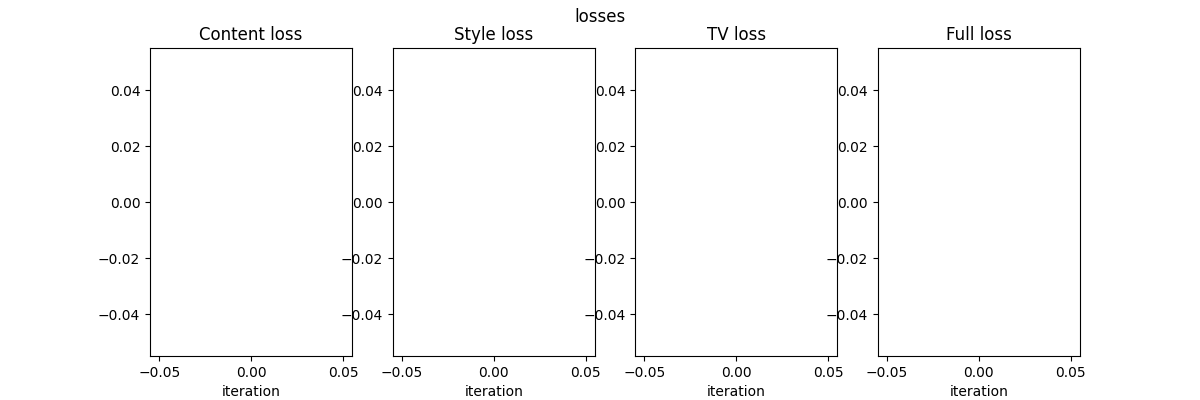

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Content loss")
ax[0].plot(losses_content)
ax[1].set_title("Style loss")
ax[1].plot(losses_style)

ax[2].set_title("TV loss")
ax[2].plot(losses_tv)
ax[3].set_title("Full loss")
ax[3].plot(losses_full)

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()

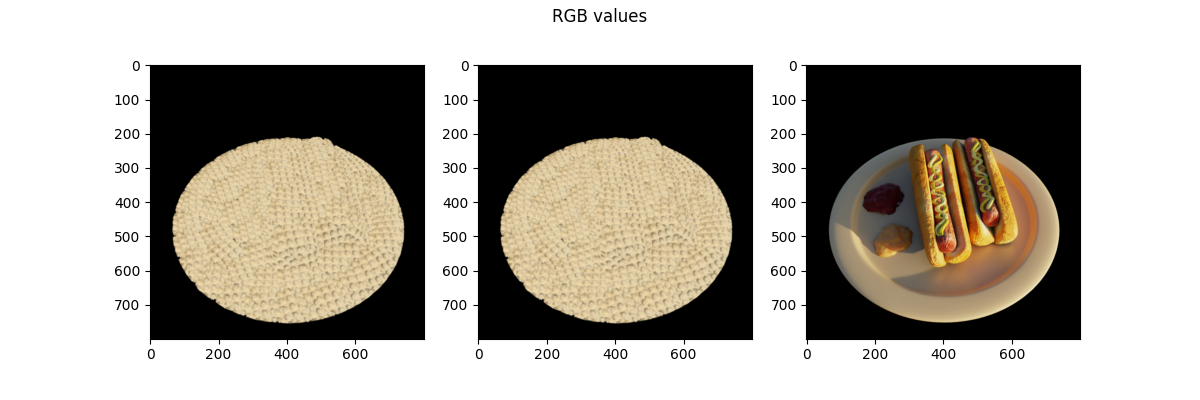

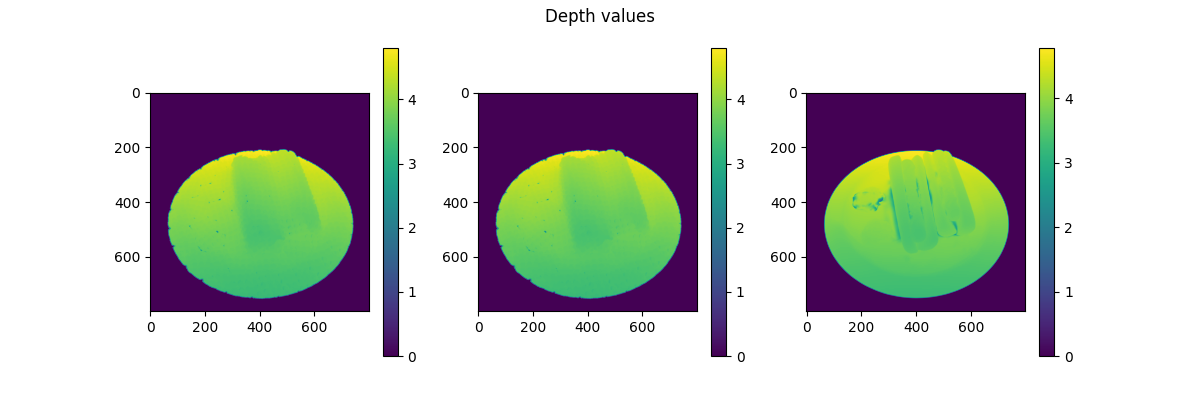

In [51]:
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        
# Optimization gaussians
render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("RGB values")
image_rgb = image_stl.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax2 = ax[2].imshow(image_rgb)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Depth values")
depth_np = depth_stl.detach().cpu().numpy()
ax0 = ax[0].imshow(depth_np)
depth_np = depth_opt.detach().cpu().numpy()
ax1 = ax[1].imshow(depth_np)
depth_np = depth_cont.detach().cpu().numpy()
ax2 = ax[2].imshow(depth_np)
fig.colorbar(ax0, ax=ax[0])
fig.colorbar(ax1, ax=ax[1])
fig.colorbar(ax2, ax=ax[2])
plt.show()

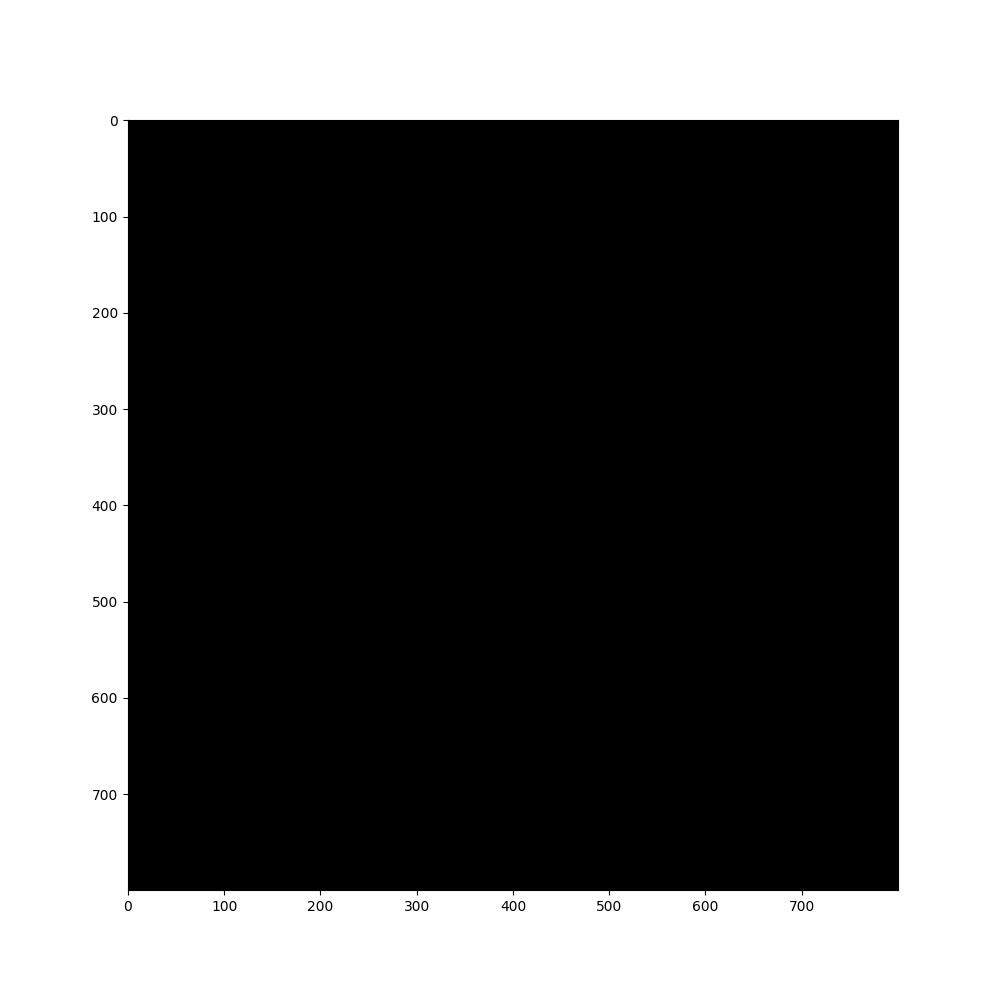

In [16]:
image_diff_rgb = (image_stl-image_opt).detach().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(10,10))
plt.imshow(image_diff_rgb)
plt.show()

In [52]:
gaussians_opt.training_setup(opt)
for param_group in gaussians_opt.optimizer.param_groups:
        param_group['lr'] = 1e-4

# gaussians_opt._xyz.requires_grad = True
# gaussians_opt._features_dc.requires_grad = True
# gaussians_opt._features_rest.requires_grad = True
# gaussians_opt._scaling.requires_grad = False
# gaussians_opt._rotation.requires_grad = False
# gaussians_opt._opacity.requires_grad = False
# gaussians_opt.max_radii2D.requires_grad = False


# gaussians_opt._xyz.requires_grad = True
# gaussians_opt._features_dc.requires_grad = True
# gaussians_opt._features_rest.requires_grad = False
# gaussians_opt._scaling.requires_grad = True
# gaussians_opt._rotation.requires_grad = False
# gaussians_opt._opacity.requires_grad = False
# gaussians_opt.max_radii2D.requires_grad = False



gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True #True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False

In [53]:
losses_content = []
losses_style = []
losses_tv = []
losses_full = []

In [54]:
def calculate_ema(values, alpha=0.01):
    ema = [values[0]]  # Initial value is the same as the first value in the list

    for i in range(1, len(values)):
        ema.append(alpha * values[i] + (1 - alpha) * ema[-1])

    return ema


In [68]:
import torch.nn.functional as F
def get_features(input_tensor, model, preprocessing=True, size=(512,512)):
    """
    For an input tensor, it returns the features of the input tensor using a pretrained VGG model
    :param input_tensor: input tensor of shape (channels, height, width)
    :param model: pretrained VGG model
    :return: features list of features
    """
    
    x = input_tensor
    # Turn in to grayscale
    x = torch.mean(input_tensor, dim=0, keepdim=True)
    x = torch.concat([x]*3)
    
    x = x.unsqueeze(0)
    x = F.interpolate(x, size=size)#(512,512)) # was (224,224)
    x = model(x)
    return x


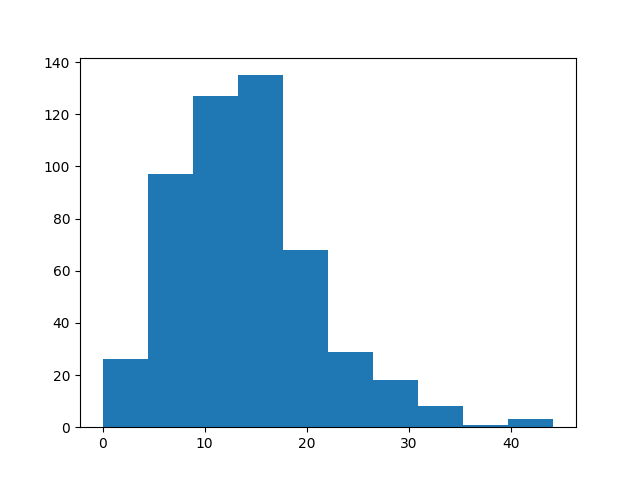

In [94]:
plt.figure()
plt.hist(torch.max(torch.max(img_cont_feats[3][0], dim=-1)[0], dim=-1)[0].detach().cpu().numpy())
plt.show()

In [69]:

def content_loss(features_gt, features_pred, thresh=0.):
    """
    Compute VGG content loss on features of the input images and compare them with the ground truth image features
    :param features_gt: ground truth image features
    :param features_pred: predicted image features
    :return: content loss
    """

    # for feat in features_gt:
    #     print("feat_gt.shape:", feat.shape)
    # for feat in features_pred:
    #     print("feat_gen.shape:", feat.shape)

    # Compute the content loss
    content_loss = 0
    for i in range(len(features_gt)):
        content_loss += torch.mean(((features_gt[i] - features_pred[i])*(features_gt[i] > thresh)) ** 2)

    return content_loss

In [70]:
image_cont.shape

torch.Size([3, 800, 800])

In [125]:
ema_loss_for_log = 0.
first_iter = 1
progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")

for iteration in range(first_iter, opt.iterations + 1):
    #gaussians_opt.update_learning_rate(iteration)

    # Every 1000 its we increase the levels of SH up to a maximum degree
    # if iteration % 1000 == 0:
    #     gaussians_opt.oneupSHdegree()

    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene_opt.getTrainCameras().copy()
        #print("viewpoint_stack:", viewpoint_stack)
    viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        


    # Optimization gaussians
    render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
    render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
    render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
    image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
    image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
    viewspace_point_tensor, visibility_filter, radii = render_pkg_opt["viewspace_points"], render_pkg_opt["visibility_filter"], render_pkg_opt["radii"]
    
    img_stl_feats_lores = get_features(input_tensor=image_stl, model=vgg, size=(224, 224))
    img_stl_feats_hires = get_features(input_tensor=image_stl, model=vgg, size=(224*3, 224*3))
    img_opt_feats_for_hires = get_features(input_tensor=image_opt, model=vgg, size=(224*3, 224*3))
    img_opt_feats_for_lores = get_features(input_tensor=image_opt, model=vgg, size=(224, 224))
    img_cont_feats = get_features(input_tensor=image_cont, model=vgg, size=(224, 224))
   
 
    # Compute losses and optimize
    layers_style = [0]
    layers_content = [3] #[2, 3]#, [2,3]
    # l_cont = content_loss([img_opt_feats_for_cont[i] for i in layers_content], [img_cont_feats[i] for i in layers_content])
    # l_cont = content_loss([img_opt_feats_for_cont[i] for i in layers_content], [img_cont_feats[i] for i in layers_content],
    #                       thresh=10.)
    l_cont = content_loss([img_opt_feats_for_lores[i] for i in layers_content],
                          [torch.maximum(img_cont_feats[i],img_stl_feats_lores[i])  for i in layers_content],
                          thresh=10.)
    l_stl = content_loss([img_opt_feats_for_hires[i] for i in layers_style], [img_stl_feats_hires[i] for i in layers_style])
    l_tv = tv_loss(image_opt)
    #loss = l_cont * 3e2 + l_stl * 1e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3
    loss = l_cont * 1e1 + l_stl * 1e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3

    loss.backward()
    
    with torch.no_grad():
        # Progress bar
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 50 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # Optimizer step
        if iteration < opt.iterations:
            gaussians_opt.optimizer.step()
            gaussians_opt.optimizer.zero_grad(set_to_none = True)

    
    losses_content.append(l_cont.data.cpu().numpy())
    losses_style.append(l_stl.data.cpu().numpy())
    losses_tv.append(l_tv.data.cpu().numpy())
    losses_full.append(loss.data.cpu().numpy())

    if (iteration % 100 == 0) and True:
        print(f"l_tv:{losses_tv[-1]:.7f}, l_cont:{losses_content[-1]:.7f}",
              f"l_stl:{losses_style[-1]:.7f}, loss:{losses_full[-1]:.7f}")
        


/tmp/ipykernel_4017236/3933578270.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")


Training progress:   0%|          | 0/29999 [00:00<?, ?it/s]

l_tv:0.0063989, l_cont:0.0236857 l_stl:0.0005552, loss:0.7920839
l_tv:0.0080108, l_cont:0.0232050 l_stl:0.0006078, loss:0.8398635
l_tv:0.0061470, l_cont:0.0462444 l_stl:0.0005420, loss:1.0044845
l_tv:0.0031047, l_cont:0.0265713 l_stl:0.0002081, loss:0.4738283
l_tv:0.0080461, l_cont:0.0271951 l_stl:0.0005953, loss:0.8672699
l_tv:0.0062254, l_cont:0.0366817 l_stl:0.0004826, loss:0.8494213


KeyboardInterrupt: 

In [407]:
ema_loss_for_log = 0.
first_iter = 1
progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")

for iteration in range(first_iter, opt.iterations + 1):
    #gaussians_opt.update_learning_rate(iteration)

    # Every 1000 its we increase the levels of SH up to a maximum degree
    if iteration % 1000 == 0:
        gaussians_opt.oneupSHdegree()

    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene_opt.getTrainCameras().copy()
        #print("viewpoint_stack:", viewpoint_stack)
    viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        


    # Optimization gaussians
    render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
    render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
    render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
    image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
    image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
    viewspace_point_tensor, visibility_filter, radii = render_pkg_opt["viewspace_points"], render_pkg_opt["visibility_filter"], render_pkg_opt["radii"]
    
    img_stl_feats = get_features(input_tensor=image_stl, model=vgg, size=(224*3, 224*3))
    img_opt_feats_for_stl = get_features(input_tensor=image_opt, model=vgg, size=(224*3, 224*3))
    img_opt_feats_for_cont = get_features(input_tensor=image_opt, model=vgg, size=(224*3, 224*3))
    img_cont_feats = get_features(input_tensor=image_cont, model=vgg, size=(224*3, 224*3))
   
 
    # Compute losses and optimize
    layers_style = [0]
    layers_content = [3] #[2, 3]#, [2,3]
    # l_cont = content_loss([img_opt_feats_for_cont[i] for i in layers_content], [img_cont_feats[i] for i in layers_content])
    # l_cont = content_loss([img_opt_feats_for_cont[i] for i in layers_content], [img_cont_feats[i] for i in layers_content],
    #                       thresh=10.)
    l_cont = content_loss([img_opt_feats_for_cont[i] for i in layers_content],
                          [torch.maximum(img_cont_feats[i],img_stl_feats[i])  for i in layers_content],
                          thresh=10.)
    l_stl = content_loss([img_opt_feats_for_stl[i] for i in layers_style], [img_stl_feats[i] for i in layers_style])
    l_tv = tv_loss(image_opt)

    #l_cont = l_stl = l_tv
    
    # loss = l_cont * 1e2 + l_stl * 4e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3
    # loss = l_cont * 0e2 + l_stl * 1e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3
    loss = l_cont * 1e2 + l_stl * 1e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3
    
    
    # if (iteration % 100 == 0) and True:
    #     print(f"l_tv:{calculate_ema(losses_tv)[-1]:.7f}, l_cont:{calculate_ema(losses_content)[-1]:.7f}",
    #           f"l_stl:{calculate_ema(losses_style)[-1]:.7f}, loss:{calculate_ema(losses_full)[-1]:.7f}")
    loss.backward()
    
    with torch.no_grad():
        # Progress bar
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 50 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # # Densification
        # if iteration < opt.densify_until_iter:
        #     # Keep track of max radii in image-space for pruning
        #     gaussians_opt.max_radii2D[visibility_filter] = torch.max(gaussians_opt.max_radii2D[visibility_filter], radii[visibility_filter])
        #     gaussians_opt.add_densification_stats(viewspace_point_tensor, visibility_filter)

        #     if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
        #         size_threshold = 20 if iteration > opt.opacity_reset_interval else None
        #         gaussians_opt.densify_and_prune(opt.densify_grad_threshold, 0.005, scene_opt.cameras_extent, size_threshold)

        #     if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
        #         gaussians_opt.reset_opacity()
        # Optimizer step
        if iteration < opt.iterations:
            gaussians_opt.optimizer.step()
            gaussians_opt.optimizer.zero_grad(set_to_none = True)

    
    losses_content.append(l_cont.data.cpu().numpy())
    losses_style.append(l_stl.data.cpu().numpy())
    losses_tv.append(l_tv.data.cpu().numpy())
    losses_full.append(loss.data.cpu().numpy())

    if (iteration % 100 == 0) and True:
        print(f"l_tv:{losses_tv[-1]:.7f}, l_cont:{losses_content[-1]:.7f}",
              f"l_stl:{losses_style[-1]:.7f}, loss:{losses_full[-1]:.7f}")
        


/tmp/ipykernel_3817643/4207727193.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")


Training progress:   0%|          | 0/29999 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacty of 31.74 GiB of which 73.12 MiB is free. Process 2919709 has 14.52 GiB memory in use. Process 99521 has 6.25 GiB memory in use. Process 2132709 has 10.89 GiB memory in use. Of the allocated memory 11.13 GiB is allocated by PyTorch, and 2.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [159]:
ema_loss_for_log = 0.
first_iter = 1
progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")

for iteration in range(first_iter, opt.iterations + 1):
    #gaussians_opt.update_learning_rate(iteration)

    # Every 1000 its we increase the levels of SH up to a maximum degree
    if iteration % 1000 == 0:
        gaussians_opt.oneupSHdegree()

    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene_opt.getTrainCameras().copy()
        #print("viewpoint_stack:", viewpoint_stack)
    viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        


    # Optimization gaussians
    render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
    render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
    render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
    image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
    image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

    viewspace_point_tensor, visibility_filter, radii = render_pkg_opt["viewspace_points"], render_pkg_opt["visibility_filter"], render_pkg_opt["radii"]

    # Visualize images.  
    if False:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
        fig.suptitle("RGB values")
        image_rgb = image_stl.detach().cpu().numpy().transpose(1, 2, 0)
        image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
        ax0 = ax[0].imshow(image_rgb)
        image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
        image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
        ax1 = ax[1].imshow(image_rgb)
        image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
        image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
        ax2 = ax[2].imshow(image_rgb)
        plt.show()

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
        fig.suptitle("Depth values")
        depth_np = depth_stl.detach().cpu().numpy()
        ax0 = ax[0].imshow(depth_np)
        depth_np = depth_opt.detach().cpu().numpy()
        ax1 = ax[1].imshow(depth_np)
        depth_np = depth_cont.detach().cpu().numpy()
        ax2 = ax[2].imshow(depth_np)
        fig.colorbar(ax0, ax=ax[0])
        fig.colorbar(ax1, ax=ax[1])
        fig.colorbar(ax2, ax=ax[2])
        plt.show()
        


    if False:
        # Compute on RGB images
        img_stl_feats = get_features(input_tensor=image_stl, model=vgg)
        img_feats = get_features(input_tensor=image_opt, model=vgg)
        img_cont_feats = get_features(input_tensor=image_cont, model=vgg)
    else:
        
        # on grayscale images
        image_stl_gray = torch.stack([torch.mean(image_stl, dim=0)]*3, dim=0)
        image_opt_gray = torch.stack([torch.mean(image_opt, dim=0)]*3, dim=0)
        image_cont_gray = torch.stack([torch.mean(image_cont, dim=0)]*3, dim=0)
        img_stl_feats = get_features(input_tensor=image_stl_gray, model=vgg)
        img_feats = get_features(input_tensor=image_opt_gray, model=vgg)
        img_cont_feats = get_features(input_tensor=image_cont_gray, model=vgg)

    # Merge features
    img_cont_feats = [torch.maximum(img_cont_feats[i], img_stl_feats[i]) for i in range(len(img_cont_feats))]
    #img_stl_feats = [torch.maximum(img_cont_feats[i], img_stl_feats[i]) for i in range(len(img_stl_feats))]
    
    # Compute losses and optimize
    layers_style = [0]
    layers_content = [3] #[2, 3]#, [2,3]
    l_cont = content_loss([img_feats[i] for i in layers_content], [img_cont_feats[i] for i in layers_content])
    l_stl = content_loss([img_feats[i] for i in layers_style], [img_stl_feats[i] for i in layers_style])
    l_tv = tv_loss(image_opt)

    #l_cont = l_stl = l_tv
    
    # loss = l_cont * 1e2 + l_stl * 4e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3
    loss = l_cont * 0e2 + l_stl * 1e3 + l_tv * 0. #1e-7 # tv_loss weight was 1e-3

    # if (iteration % 100 == 0) and True:
    #     print(f"l_tv:{calculate_ema(losses_tv)[-1]:.7f}, l_cont:{calculate_ema(losses_content)[-1]:.7f}",
    #           f"l_stl:{calculate_ema(losses_style)[-1]:.7f}, loss:{calculate_ema(losses_full)[-1]:.7f}")
    loss.backward()
    
    with torch.no_grad():
        # Progress bar
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 50 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # # Densification
        # if iteration < opt.densify_until_iter:
        #     # Keep track of max radii in image-space for pruning
        #     gaussians_opt.max_radii2D[visibility_filter] = torch.max(gaussians_opt.max_radii2D[visibility_filter], radii[visibility_filter])
        #     gaussians_opt.add_densification_stats(viewspace_point_tensor, visibility_filter)

        #     if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
        #         size_threshold = 20 if iteration > opt.opacity_reset_interval else None
        #         gaussians_opt.densify_and_prune(opt.densify_grad_threshold, 0.005, scene_opt.cameras_extent, size_threshold)

        #     if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
        #         gaussians_opt.reset_opacity()
        # Optimizer step
        if iteration < opt.iterations:
            gaussians_opt.optimizer.step()
            gaussians_opt.optimizer.zero_grad(set_to_none = True)

    
    losses_content.append(l_cont.data.cpu().numpy())
    losses_style.append(l_stl.data.cpu().numpy())
    losses_tv.append(l_tv.data.cpu().numpy())
    losses_full.append(loss.data.cpu().numpy())

    if (iteration % 100 == 0) and True:
        print(f"l_tv:{losses_tv[-1]:.7f}, l_cont:{losses_content[-1]:.7f}",
              f"l_stl:{losses_style[-1]:.7f}, loss:{losses_full[-1]:.7f}")
        


/tmp/ipykernel_3817643/2853075806.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")


Training progress:   0%|          | 0/29999 [00:00<?, ?it/s]

l_tv:0.0078378, l_cont:1.0992446 l_stl:0.0021939, loss:2.1938586
l_tv:0.0060764, l_cont:0.9945658 l_stl:0.0015884, loss:1.5884483
l_tv:0.0074461, l_cont:1.1750898 l_stl:0.0017309, loss:1.7309399
l_tv:0.0081708, l_cont:1.1669986 l_stl:0.0017210, loss:1.7210340
l_tv:0.0083440, l_cont:1.2410377 l_stl:0.0016613, loss:1.6612659


KeyboardInterrupt: 

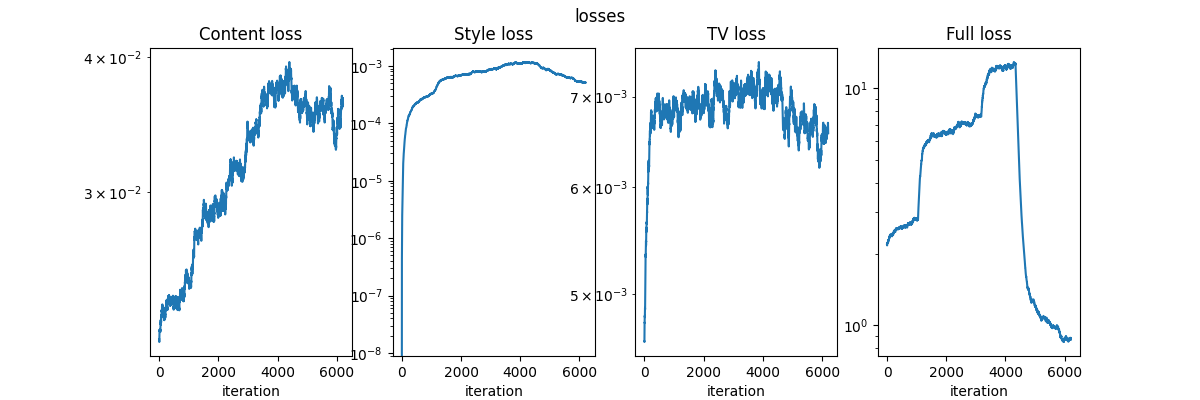

In [126]:

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Content loss")
ax[0].plot(calculate_ema(losses_content))
ax[1].set_title("Style loss")
ax[1].plot(calculate_ema(losses_style))

ax[2].set_title("TV loss")
ax[2].plot(calculate_ema(losses_tv))
ax[3].set_title("Full loss")
ax[3].plot(calculate_ema(losses_full))

for i in range(4): 
    ax[i].set_xlabel("iteration")
    ax[i].set_yscale('log')

plt.show()

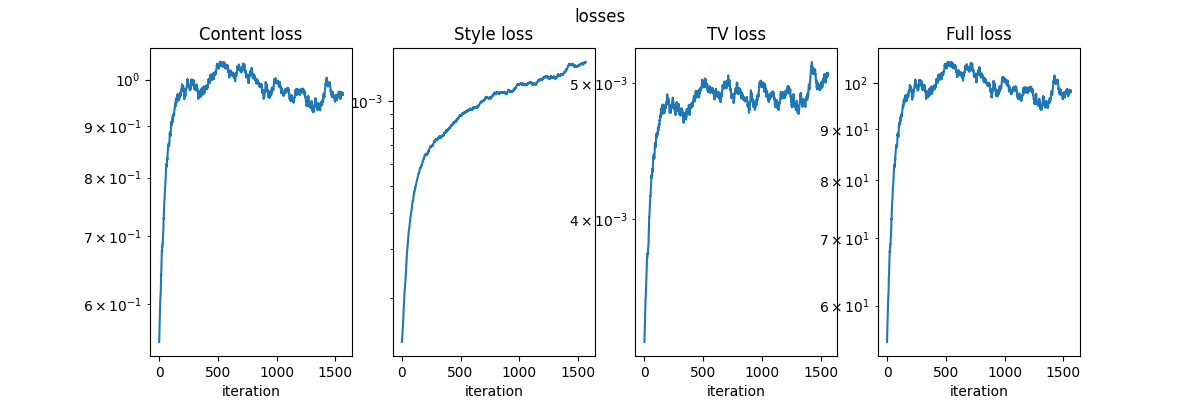

In [64]:

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Content loss")
ax[0].plot(calculate_ema(losses_content))
ax[1].set_title("Style loss")
ax[1].plot(calculate_ema(losses_style))

ax[2].set_title("TV loss")
ax[2].plot(calculate_ema(losses_tv))
ax[3].set_title("Full loss")
ax[3].plot(calculate_ema(losses_full))

for i in range(4): 
    ax[i].set_xlabel("iteration")
    ax[i].set_yscale('log')

plt.show()

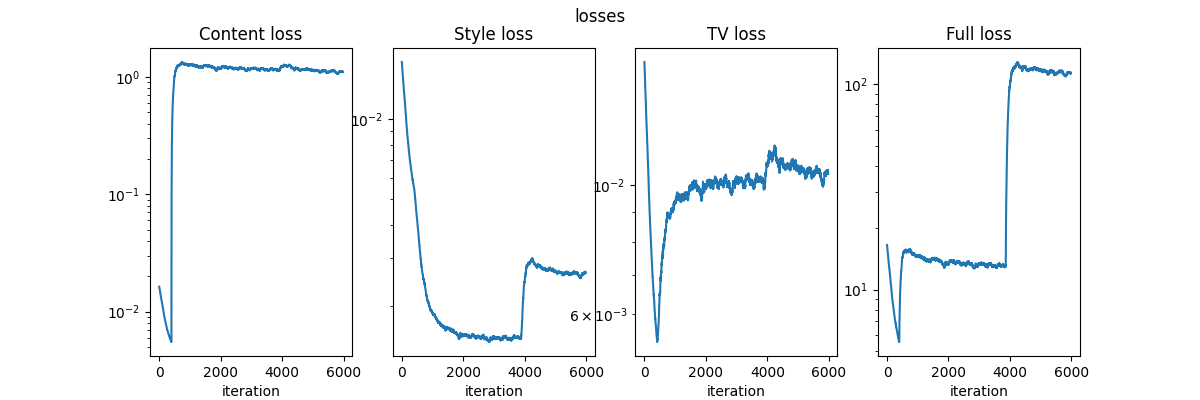

In [29]:

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Content loss")
ax[0].plot(calculate_ema(losses_content))
ax[1].set_title("Style loss")
ax[1].plot(calculate_ema(losses_style))

ax[2].set_title("TV loss")
ax[2].plot(calculate_ema(losses_tv))
ax[3].set_title("Full loss")
ax[3].plot(calculate_ema(losses_full))

for i in range(4): 
    ax[i].set_xlabel("iteration")
    ax[i].set_yscale('log')

plt.show()

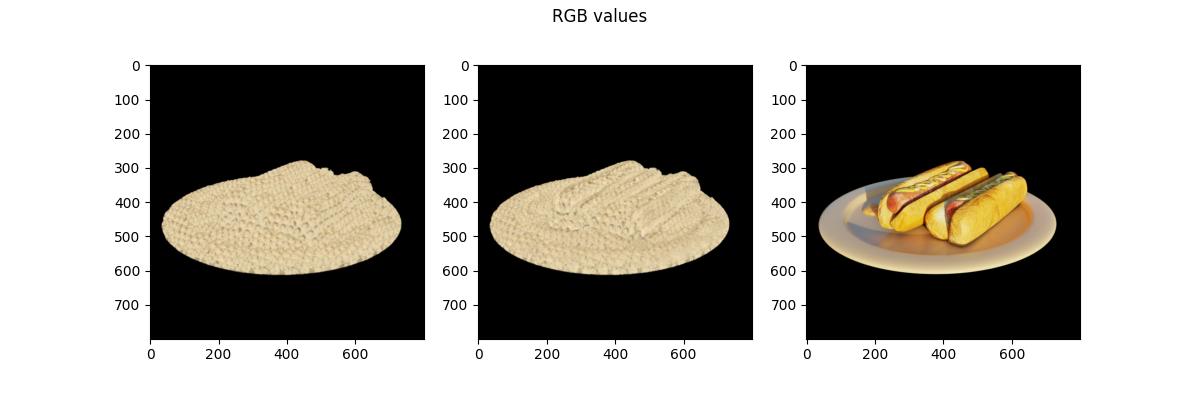

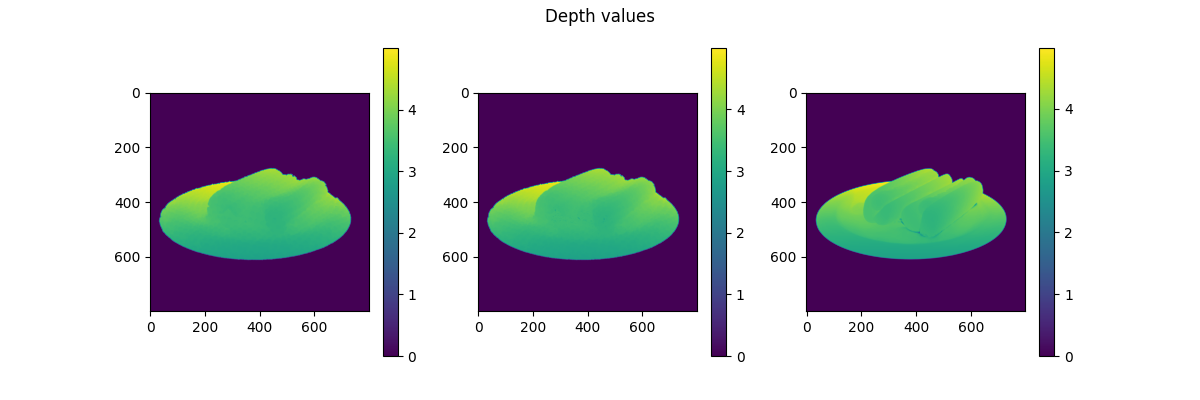

In [130]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        
# Optimization gaussians
render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("RGB values")
image_rgb = image_stl.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax2 = ax[2].imshow(image_rgb)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Depth values")
depth_np = depth_stl.detach().cpu().numpy()
ax0 = ax[0].imshow(depth_np)
depth_np = depth_opt.detach().cpu().numpy()
ax1 = ax[1].imshow(depth_np)
depth_np = depth_cont.detach().cpu().numpy()
ax2 = ax[2].imshow(depth_np)
fig.colorbar(ax0, ax=ax[0])
fig.colorbar(ax1, ax=ax[1])
fig.colorbar(ax2, ax=ax[2])
plt.show()

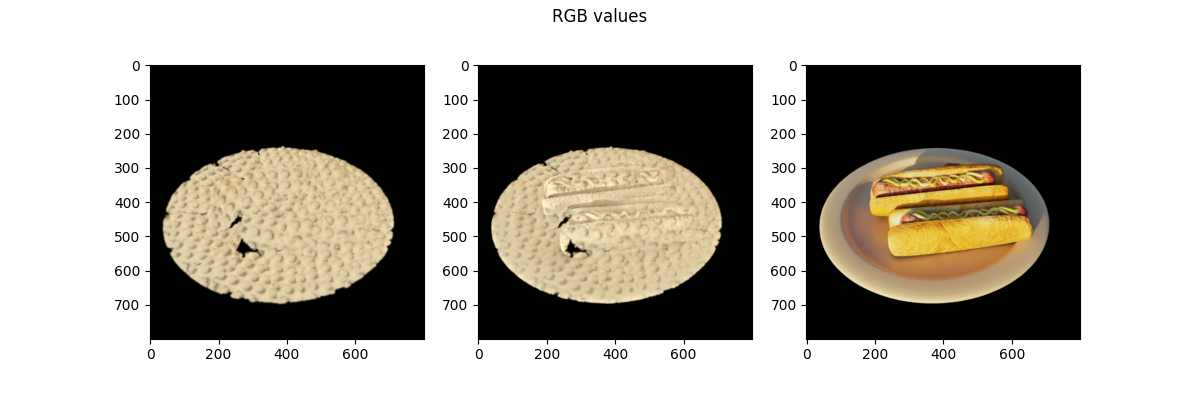

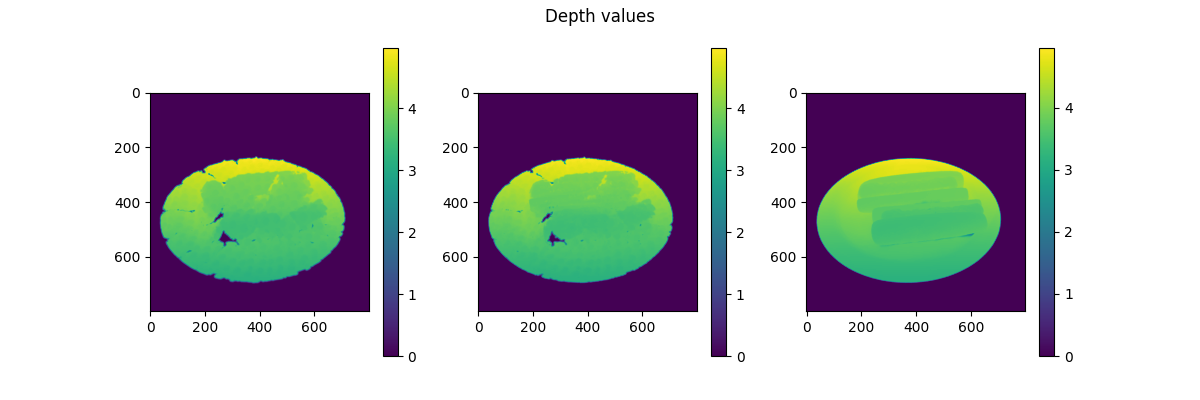

In [69]:
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        
# Optimization gaussians
render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("RGB values")
image_rgb = image_stl.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax2 = ax[2].imshow(image_rgb)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Depth values")
depth_np = depth_stl.detach().cpu().numpy()
ax0 = ax[0].imshow(depth_np)
depth_np = depth_opt.detach().cpu().numpy()
ax1 = ax[1].imshow(depth_np)
depth_np = depth_cont.detach().cpu().numpy()
ax2 = ax[2].imshow(depth_np)
fig.colorbar(ax0, ax=ax[0])
fig.colorbar(ax1, ax=ax[1])
fig.colorbar(ax2, ax=ax[2])
plt.show()

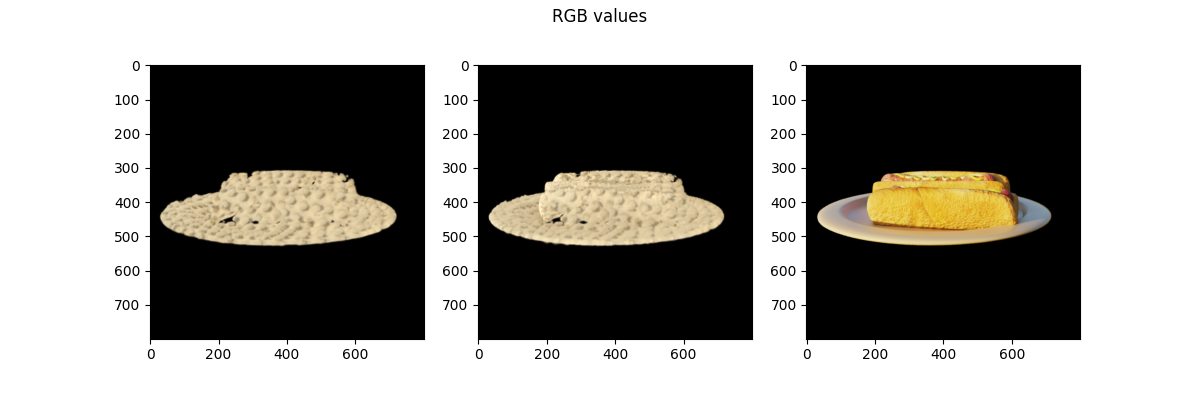

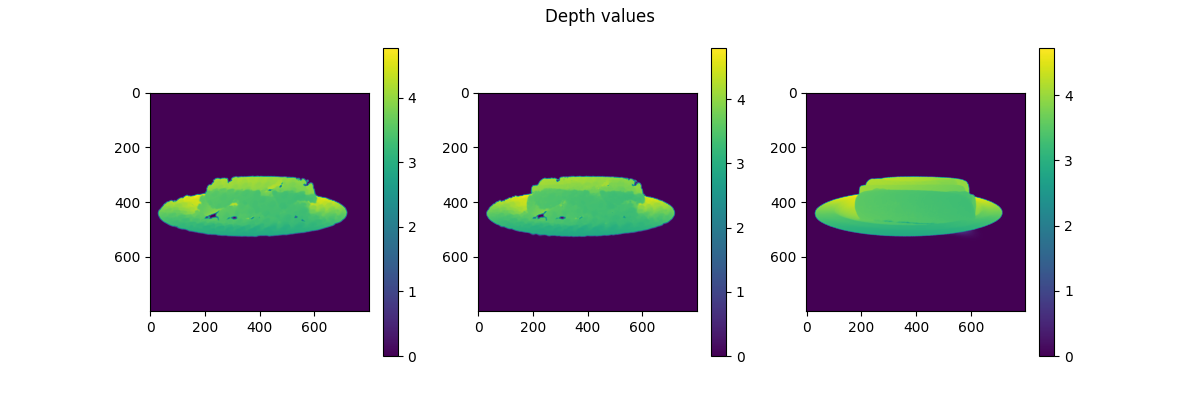

In [70]:
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        
# Optimization gaussians
render_pkg_stl = render(viewpoint_cam, gaussians_stl, pipe, background)
render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
render_pkg_cont = render(viewpoint_cam, gaussians_cont, pipe, background)
image_stl, depth_stl= render_pkg_stl["render"], render_pkg_stl["depth"]
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("RGB values")
image_rgb = image_stl.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax0 = ax[0].imshow(image_rgb)
image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax1 = ax[1].imshow(image_rgb)
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
ax2 = ax[2].imshow(image_rgb)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Depth values")
depth_np = depth_stl.detach().cpu().numpy()
ax0 = ax[0].imshow(depth_np)
depth_np = depth_opt.detach().cpu().numpy()
ax1 = ax[1].imshow(depth_np)
depth_np = depth_cont.detach().cpu().numpy()
ax2 = ax[2].imshow(depth_np)
fig.colorbar(ax0, ax=ax[0])
fig.colorbar(ax1, ax=ax[1])
fig.colorbar(ax2, ax=ax[2])
plt.show()

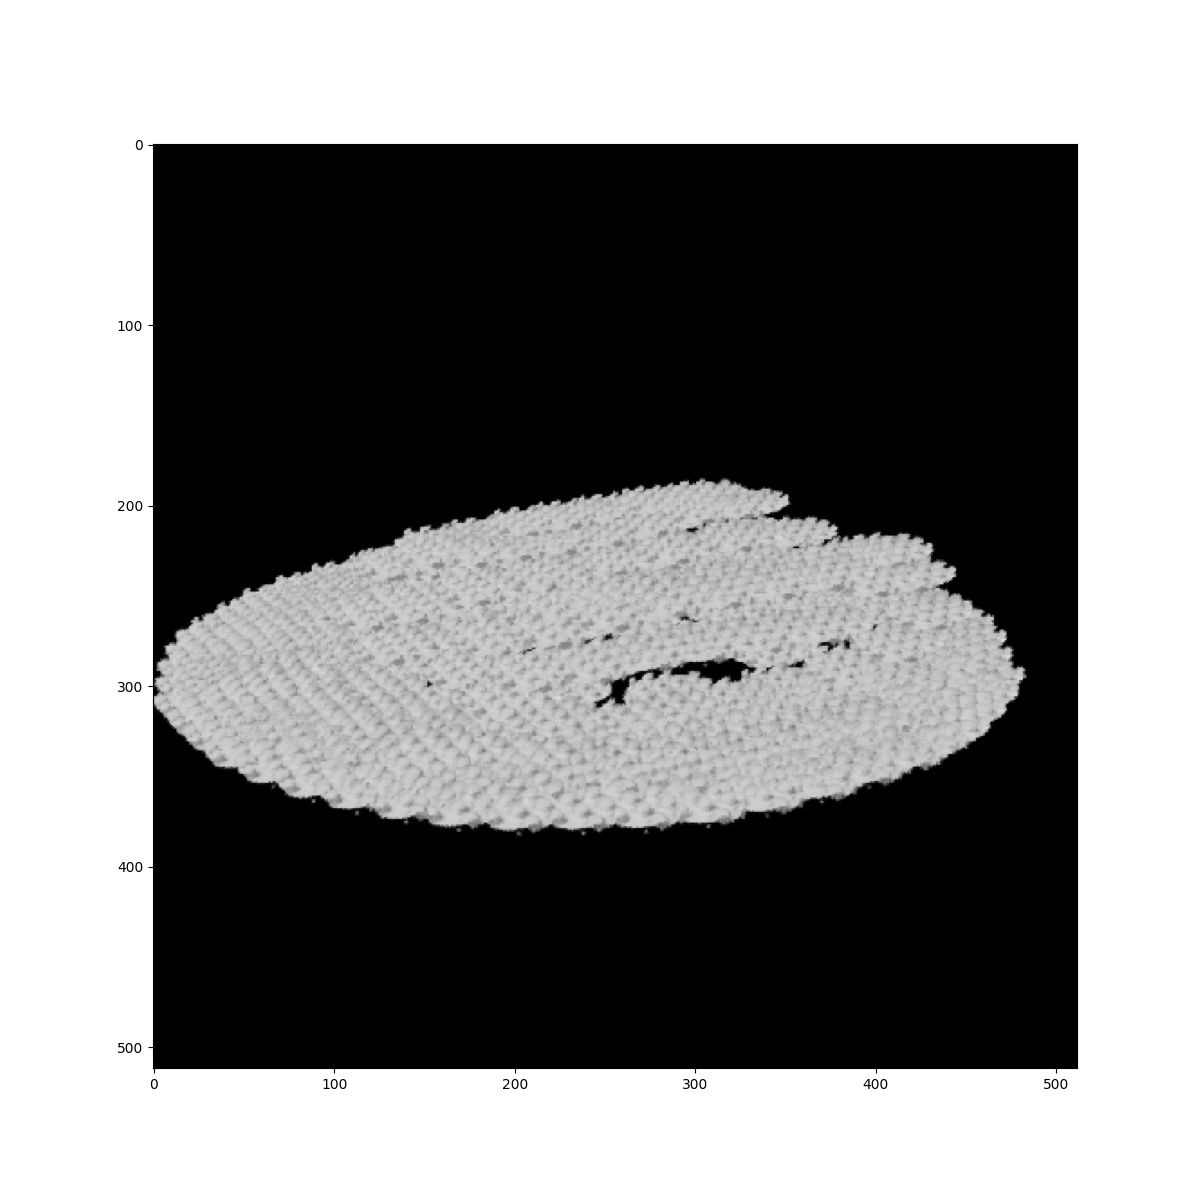

In [236]:

import torch.nn.functional as F
plt.figure(figsize=(12,12))

image_rgb = F.interpolate(image_stl_gray.unsqueeze(0), size=(512, 512)).squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
plt.imshow(image_rgb)
plt.show()


In [ ]:

image_rgb = image_stl_gray.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

In [46]:
viewpoint_stack

[]

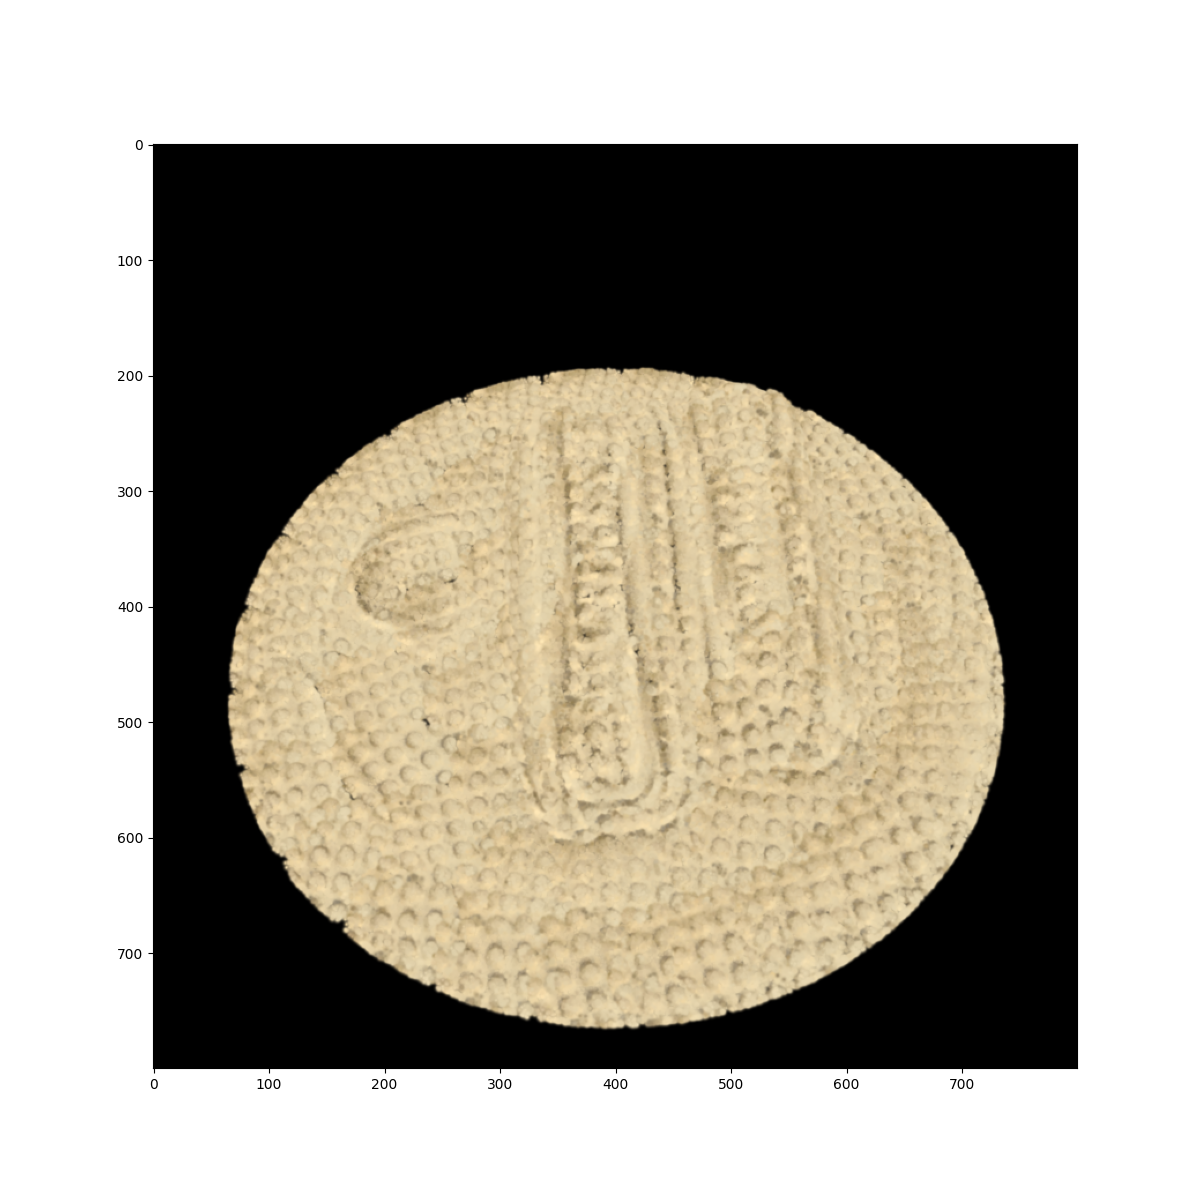

In [133]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
scaling_factor = 1. #.99
with torch.no_grad():
    # gaussians_opt._scaling.data = gaussians_opt._scaling.data + torch.ones_like(gaussians_opt._scaling.data)*0.1
    gaussians_opt._scaling.data = gaussians_opt._scaling.data*scaling_factor
    
plt.figure(figsize=(12,12))
render_pkg_opt = render(viewpoint_cam, gaussians_opt, pipe, background)
image_opt, depth_opt= render_pkg_opt["render"], render_pkg_opt["depth"]
image_rgb = image_opt.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
plt.imshow(image_rgb)
plt.show()

with torch.no_grad():
    # gaussians_opt._scaling.data = gaussians_opt._scaling.data - torch.ones_like(gaussians_opt._scaling.data)*0.1
    gaussians_opt._scaling.data = gaussians_opt._scaling.data/scaling_factor

## Save results

In [134]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
MODEL_DIR_NEW = './GT_hotdog_lego_ntbk16_from_init_ntbk20_stlztn8/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR




In [135]:
#gaussians_opt.training_setup(opt)

In [136]:

iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))
